```{try_on_binder}
```

In [1]:

from IPython import get_ipython
ip = get_ipython()
if ip is not None:
    ip.run_line_magic('load_ext', 'pymor.discretizers.builtin.gui.jupyter')
    ip.run_line_magic('matplotlib', 'inline')

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='torch')
import pymor.tools.random
pymor.tools.random._default_random_state = None



The pymor.discretizers.builtin.gui.jupyter extension is already loaded. To reload it, use:
  %reload_ext pymor.discretizers.builtin.gui.jupyter


# Tutorial: Model order reduction for unstable LTI systems

In {doc}`tutorial_lti_systems` we introduced LTI systems of the form

```{math}
\begin{align}
    E \dot{x}(t) & = A x(t) + B u(t), \\
    y(t) & = C x(t) + D u(t).
\end{align}
```

If the system is asymptotically stable, i.e., all eigenvalues of the
matrix pair {math}`(A, E)` lie in the open left half plane, methods like
balanced truncation (see {doc}`tutorial_bt`) can be used for model
order reduction. Asymptotic stability of the LTI system is a crucial
assumption for balanced truncation because the observability and
controllability Gramians are not defined if the matrix pair {math}`(A, E)` has
eigenvalues with a positive real part (in this case we call the LTI system
unstable). Additionally, commonly used system norms like the
{math}`\mathcal{H}_2` norm, the {math}`\mathcal{H}_\infty` norm, and
the Hankel (semi)norm are not defined for unstable LTI systems.

In this tutorial we show how unstable LTI systems with an invertible
{math}`E` matrix can be reduced using pyMOR.

## An unstable model

We consider the following one-dimensional heat equation over {math}`(0, 1)` with
one input {math}`u(t)` and one output {math}`y(t)`:

```{math}
\begin{align}
    \partial_t T(\xi, t) & = \partial_{\xi \xi} T(\xi, t) + \lambda T(\xi, t),
    & 0 < \xi < 1,\ t > 0, \\
    -\partial_\xi T(0, t) & = -T(0, t) + u(t),
    & t > 0, \\
    \partial_\xi T(1, t) & = -T(1, t),
    & t > 0, \\
    y(t) & = T(1, t),
    & t > 0.
\end{align}
```

Depending on the choice of the parameter {math}`\lambda` the discretization of
the above partial differential equation is an unstable LTI system. In order to
build the {{ LTIModel }} we follow the lines of {doc}`tutorial_lti_systems`.

First, we do the necessary imports and some matplotlib style choices.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sps
from pymor.models.iosys import LTIModel

plt.rcParams['axes.grid'] = True

Next, we can assemble the matrices based on a centered finite difference
approximation using standard methods of NumPy and SciPy. Here we use
{math}`\lambda = 50`.

In [3]:

k = 50
n = 2 * k + 1
l = 50

E = sps.eye(n, format='lil')
E[0, 0] = E[-1, -1] = 0.5
E = E.tocsc()

d0 = n * [-2 * (n - 1)**2 + l]
d1 = (n - 1) * [(n - 1)**2]
A = sps.diags([d1, d0, d1], [-1, 0, 1], format='lil')
A[0, 0] = A[-1, -1] = -n * (n - 1) + l / 2
A = A.tocsc()

B = np.zeros((n, 1))
B[0, 0] = n - 1

C = np.zeros((1, n))
C[0, -1] = 1


Then, we can create an {{ LTIModel }} from NumPy and SciPy matrices `A`, `B`, `C`,
`E`.

In [4]:
fom = LTIModel.from_matrices(A, B, C, E=E)

First, let's check whether our system is indeed unstable. For this, we can use the
method {meth}`~pymor.models.iosys.LTIModel.get_ast_spectrum`, which will
compute the subset of system poles with a positive real part and the corresponding
eigenvectors as well.

In [5]:
ast_spectrum = fom.get_ast_spectrum()
print(ast_spectrum[1])

[ 6.65573911+0.j 36.50842397+0.j 48.29293004+0.j]


In the code snippet above, all eigenvalues of the matrix pair {math}`(A, E)` are
computed using dense methods. This works well for systems with a small state space
dimension. For large-scale systems it is wiser to rely on iterative methods for
computing eigenvalues. The code below computes 10 system poles which are
close to 0 using pyMOR's iterative eigensolver and filters the result for
values with a positive real part.

In [6]:
ast_spectrum = fom.get_ast_spectrum(ast_pole_data={'k': 10, 'sigma': 0})
print(ast_spectrum[1])

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

[ 6.65573911+0.j 36.50842397+0.j 48.29293004+0.j]


## Frequency domain balanced truncation

The observability and controllability Gramians (defined in the time-domain)
introduced in {doc}`tutorial_lti_systems` do not exist for unstable systems.
However, the frequency domain representations of these Gramians are defined for
systems with no poles on the imaginary axis. Hence, for most unstable systems we
can follow a similar approach to the one from {doc}`tutorial_bt` but using the
frequency domain representations of the controllability and observability Gramians

```{math}
\begin{align*}
    P & =
    \frac{1}{2 \pi} \int_{-\infty}^\infty
    (\imath \omega E - A)^{-1}
    B B^{\operatorname{T}}
    (-\imath \omega E^{\operatorname{T}} - A^{\operatorname{T}})^{-1}
    \operatorname{d}\!\omega, \text{ and} \\
    E^{\operatorname{T}} Q E & =
    \frac{1}{2 \pi} E^{\operatorname{T}} \int_{-\infty}^\infty
    (-\imath \omega E^{\operatorname{T}} - A^{\operatorname{T}})^{-1}
    C^{\operatorname{T}} C
    (\imath \omega E - A)^{-1}
    \operatorname{d}\!\omega\, E.
\end{align*}
```

Again, two Lyapunov equations have to be solved in order to obtain these Gramians.
Additionally, it is necessary to perform a Bernoulli stabilization of the system
matrices before solving the matrix equations. Both of these steps are done internally
by the {class}`~pymor.reductors.bt.FDBTReductor`.

Let us start with initializing a reductor object

In [7]:
from pymor.reductors.bt import FDBTReductor
fdbt = FDBTReductor(fom, ast_pole_data={'k': 10, 'sigma': 0})

In order to perform a Bernoulli stabilization, knowledge about the anti-stable
subset of system poles is required. With the `ast_pole_data` argument we can provide
information about the system poles to the reductor (i.e. list of anti-stable
eigenvalues with or without corresponding eigenvectors) or specify how eigenvalues
should be computed (i.e. `None` for computing all eigenvalues using dense methods
or arguments for pyMOR's iterative eigensolver like in the code above).

Before we use the {meth}`~pymor.reductors.bt.FDBTReductor.reduce` method to
obtain a reduced-order model, we take a look at some a priori error bounds for
the reductor. In particular, we get a {math}`\mathcal{L}_\infty` rather than the
{math}`\mathcal{H}_\infty` error bound from classic balanced truncation.

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

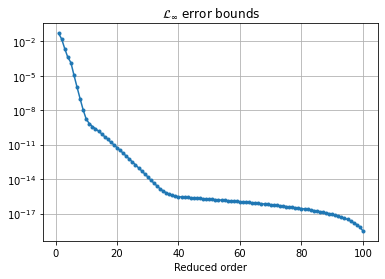

In [8]:
error_bounds = fdbt.error_bounds()
fig, ax = plt.subplots()
ax.semilogy(range(1, len(error_bounds) + 1), error_bounds, '.-')
ax.set_xlabel('Reduced order')
_ = ax.set_title(r'$\mathcal{L}_\infty$ error bounds')

To get a reduced-order model of order 10, we call the `reduce` method with the
appropriate argument:

In [9]:
rom = fdbt.reduce(10)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

Alternatively, we can specify a desired error tolerance rather than the order
of the reduced model.

Finally, we can compute the relative {math}`\mathcal{L}_\infty` error to check
the quality of the reduced-order model.

In [10]:
err = fom - rom
print(f'Relative Linf error:   {err.linf_norm() / fom.linf_norm():.3e}')

Relative Linf error:   2.973e-09


Clearly, this result is in accordance with our previously computed
{math}`\mathcal{L}_\infty` error bound:

In [11]:
print(f'Linf error:   {err.linf_norm():.3e}')
print(f'Linf upper bound:   {error_bounds[9]:.3e}')

Linf error:   8.477e-10
Linf upper bound:   1.657e-09


## Gap-IRKA

The {class}`~pymor.reductors.h2.IRKAReductor` is specifically designed to find
{math}`\mathcal{H}_2`-optimal reduced-order models (see e.g. {cite}`GAB08`).
Since we cannot compute {math}`\mathcal{H}_2`-norms for unstable systems,
we can not expect the IRKA to yield high-quality approximations for unstable
full-order models.
In {cite}`BBG19` the authors introduce a variant of the IRKA (the Gap-IRKA) which
is based on the {math}`\mathcal{H}_2`-gap-norm.
As desired, this norm is defined for most unstable systems which makes the
Gap-IRKA a suitable algorithm for finding reduced-order models for unstable systems.

One major advantage of the {class}`~pymor.reductors.h2.GapIRKAReductor` over the
{class}`~pymor.reductors.bt.FDBTReductor` is that
no a priori information about the system poles is required. However, we do not
obtain an a priori {math}`\mathcal{L}_\infty` error bound. Let us compute a
reduced-order model of order 10 using the {class}`~pymor.reductors.h2.GapIRKAReductor`.

In [12]:
from pymor.reductors.h2 import GapIRKAReductor
gapirka = GapIRKAReductor(fom)
rom = gapirka.reduce(10)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

Beside the desired order of the reduced model, the `reduce` method has a few
other arguments as well: `conv_crit` allows for choosing the stopping criterion
of the algorithm. By specifying `conv_crit='sigma'` the relative change in
interpolation points, `conv_crit='htwogap'` the relative change in
{math}`\mathcal{H}_2`-gap distance of the reduced-order models and `conv_crit='ltwo'` the
relative change of {math}`\mathcal{L}_2` distances of the reduced-order models are
used as a stopping criterion. The `tol` argument sets the tolerance for
any of the chosen stopping criterion.

Again, we can compute the relative {math}`\mathcal{L}_\infty` error.

In [13]:
err = fom - rom
print(f'Relative Linf error:   {err.linf_norm() / fom.linf_norm():.3e}')

Relative Linf error:   2.849e-09


Download the code:
{download}`tutorial_unstable_lti_systems.md`,
{nb-download}`tutorial_unstable_lti_systems.ipynb`.